In [1]:
# import the packages
import re
import simpy
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create the Echo class for the simulation
class Echo:
    def __init__(self, time_start, time_close, num_fetal_room, num_nonfetal_room, num_sonographer_both,
                 num_sonographer_nonfetal, time_sonographer_break, rate_sonographer_leave, rate_absence,
                 ontime_anger, late_anger, render_env):
        self.time_start = time_start
        self.time_close = time_close
        self.num_fetal_room = num_fetal_room
        self.num_nonfetal_room = num_nonfetal_room
        self.num_sonographer_both = num_sonographer_both
        self.num_sonographer_nonfetal = num_sonographer_nonfetal
        self.time_sonographer_break = time_sonographer_break
        self.rate_sonographer_leave = rate_sonographer_leave
        self.rate_absence = rate_absence
        self.ontime_anger = ontime_anger
        self.late_anger = late_anger
        self.render_env = render_env
        self.state = {
            'patients':[],
            'sonographers': [],
            'rooms': []
        }
        self.actions = [0, 1, 2, 3, 4, 5, 6,]

        
    # create two functions to convert the time to steps and steps to time        
    def convert_to_time(self, steps):
        start_hours, start_minutes = map(int, self.time_start.split(':'))
        hours = int((start_hours * 60 + start_minutes + steps) // 60)
        minutes = int((start_hours * 60 + start_minutes + steps) % 60)
        return "{:02d}:{:02d}".format(hours, minutes)
        
    def convert_to_step (self, time):
        hours, minutes = map(int, time.split(':'))
        step = hours * 60 + minutes - 480
        return step
    
    
    # create a function to store all the appointments of the day (by steps)
    def _load_schedules(self):
        # calculate the number of time steps based on the time range
        time_range = self.convert_to_step(self.time_close) - self.convert_to_step(self.time_start)
        # create a variable to track the patients
        num = 0
        # Iterate over each time step
        for time in range(time_range):
            # Check if it's time to schedule a fetal patient (assuming 60 is the interval)
            if time % 60 == 0:
                self.state['patients'].append({'patient number': num,
                                               'status': 'incoming', # incoming, waiting (late,early,ontime), testing, done
                                               'Schedule time': time,
                                               'Arrival time': 'NA',
                                               'fetal': 'yes',
                                               'subspecialty': 'na'})
                num+=1
            # Check if it's time to schedule a nonfetal patient (assuming 30 is the interval)
            if time % 30 == 0:
                # Check specific intervals where there are two appointments
                if (self.convert_to_step('10:30') <= time <= self.convert_to_step('12:30'))\
                   or (self.convert_to_step('14:00') <= time <= self.convert_to_step('15:30')):
                    self.state['patients'].append({'patient number': num,
                                               'status': 'incoming',
                                               'Schedule time': time,
                                               'Arrival time': 'NA',
                                               'fetal': 'no',
                                               'subspecialty': 'na'})
                    num+=1
                    self.state['patients'].append({'patient number': num,
                                               'status': 'incoming',
                                               'Schedule time': time,
                                               'Arrival time': 'NA',
                                               'fetal': 'no',
                                               'subspecialty': 'na'})
                    num+=1
                # Otherwise there is one appointment scheduled
                else:
                    self.state['patients'].append({'patient number': num,
                                               'status': 'incoming',
                                               'Schedule time': time,
                                               'Arrival time': 'NA',
                                               'fetal': 'no',
                                               'subspecialty': 'na'})
                    num+=1
            # Handle specific appointments made at different times
            if time in [self.convert_to_step('10:45'), self.convert_to_step('11:45')]:
                self.state['patients'].append({'patient number': num,
                                               'status': 'incoming',
                                               'Schedule time': time,
                                               'Arrival time': 'NA',
                                               'fetal': 'no',
                                               'subspecialty': 'na'})
                num+=1 
       
    
    # create two functions to simulate the arrival time of nonfetal patients and fetal patients respectively    
    def _nonfetal_arrival_time(self, patient):
        random_number = random.random()
        # get the schedule time of the patients
        schedule_steps = patient['Schedule time'] 
        # 10% patient arrives on time
        if random_number < 0.1:
            arrival_steps = schedule_steps
        # 80% patient arrives later than the schedule
        elif random_number < 0.9:
            arrival_steps = np.random.exponential(20, size=1) + schedule_steps
         # 10% patient arrives earlier than the schedule
        else:
            arrival_steps = -np.random.exponential(5, size=1) + schedule_steps
        # if the patient comes before the openning time of the hospital, record the arrival time as the openning time    
        if arrival_steps < 0:
            arrival_steps = 0
        # patient can't arrives one hour earlier
        if arrival_steps - schedule_steps < -60:
            arrival_steps = -60 + schedule_steps
        # convert the arrivial_steps to an integer
        arrival_steps = int(arrival_steps)
        # record the arrival time only if the patients come before closing time and not absent
        random_number = random.random()
        if arrival_steps <= self.convert_to_step(self.time_close) and random_number > self.rate_absence:
            yield self.env.timeout(arrival_steps)
            patient['Arrival time'] = arrival_steps
            if arrival_steps - schedule_steps > 10:
                patient['status'] = 'waiting(late)'
            elif arrival_steps - schedule_steps < -10:
                patient['status'] = 'waiting(early)'
            else:
                patient['status'] = 'waiting(ontime)'
            
            
    def _fetal_arrival_time(self, patient):                                                         
        random_number = random.random()
        schedule_steps = patient['Schedule time'] 
        # 10% patient arrives on time
        if random_number < 0.1:
            arrival_steps = schedule_steps
        # 80% patient arrives later than the schedule time
        elif random_number < 0.9:
            arrival_steps = np.random.exponential(20, size=1) + schedule_steps
         # 10% patient arrives earlier than the schedule time
        else:
            arrival_steps = -np.random.exponential(5, size=1) + schedule_steps
        # if the patient comes before the openning time of the hospital, record the arrival time as the openning time    
        if arrival_steps < 0:
            arrival_steps = 0
        # patient can't arrives one hour earlier
        if arrival_steps - schedule_steps < -60:
            arrival_steps = -60 + schedule_steps
        # convert the arrivial_steps to an integer
        arrival_steps = int(arrival_steps)
        # record the arrival time only if the patients come before closing time and not absent
        random_number = random.random()
        if arrival_steps <= self.convert_to_step(self.time_close) and random_number > self.rate_absence:
            yield self.env.timeout(arrival_steps)
            patient['Arrival time'] = arrival_steps
            if arrival_steps - schedule_steps > 10:
                patient['status'] = 'waiting(late)'
            elif arrival_steps - schedule_steps < -10:
                patient['status'] = 'waiting(early)'
            else:
                patient['status'] = 'waiting(ontime)'
            
    
    # create a function to load the patients
    def _load_patients(self):
        # Iterate over each time step
        for patient in self.state['patients']:
            if patient['fetal'] == 'yes':
                self.env.process(self._fetal_arrival_time(patient))
            else:
                self.env.process(self._nonfetal_arrival_time(patient))
                
                    
    # load the sonographers
    def _load_sonographers(self):
         # single out a fetal sonographer as the reserved one for the future policy function and there is at least one
         # fetal sonographer and at least one non fetal sonographer for the program to run
        self.state['sonographers'].append({'sonographer number':0 ,
                                                'fetal':'yes (reserved)',
                                                'status': 'available',  # available, break, leave, working, reserved
                                                'break times':2}) #the remainning break times
        for i in range(self.num_sonographer_both-1):
            if random.random() < 0.9:  # 90% probability the sonographer can work that day
                status = 'available'
            else:
                status = 'leave'
            self.state['sonographers'].append({'sonographer number':i+1,
                                                'fetal':'yes',
                                                'status': status,  # available, break, leave, working, reserved
                                                'break times':2}) #the remainning break times
        self.state['sonographers'].append({'sonographer number':self.num_sonographer_both ,
                                                'fetal':'no',
                                                'status': 'available',  # available, break, leave, working, reserved
                                                'break times':2}) #the remainning break times    
        for i in range(self.num_sonographer_nonfetal-1):
            if random.random() < 0.9:  # 90% probability
                status = 'available'
            else:
                status = 'leave'
            self.state['sonographers'].append({'sonographer number': i + 1 + self.num_sonographer_both,
                                               'fetal': 'no',
                                               'status': status,
                                               'break times': 2})

            
    # load the echo rooms
    def _load_rooms(self):
        # single out an fetal echo room as the reserved one for the future policy function
        self.state['rooms'].append({'room number':0 ,
                                    'status': 'available',
                                    'fetal':'yes (reserved)'})# available, break, leave, working, reserved
        for i in range(self.num_fetal_room-1):
            self.state['rooms'].append({'room number':i+1 ,
                                        'fetal':'yes',
                                        'status': 'available'})  # available, working
        for i in range(self.num_nonfetal_room):
            self.state['rooms'].append({'room number':i + self.num_fetal_room,
                                        'fetal':'no',
                                        'status': 'available'})

            
            
    # simulate the spell time of the echo test                                                           
    def _spell_time(self, sonographer_num, room_num, patient_num):
        spell_time = int(np.random.exponential(60, size=1))
        # no echo test takes more than 150 mins
        if spell_time > 150:
            spell_time = 150
        if spell_time <=30:
            spell_time = 30
        yield self.env.timeout(spell_time)
        # change the status of the patient to 'done' and room to 'available' after the test
        self.state['patients'][patient_num]['status']='done'
        self.state['rooms'][room_num]['status']='available'
        if  self.state['sonographers'][sonographer_num]['break times'] == 2:
            random_number = random.random()
            # 20% the sonographer takes two breaks together
            if random_number < 0.2:                  
                self.state['sonographers'][sonographer_num]['status'] = 'break'
                self.state['sonographers'][sonographer_num]['break times'] = 0                 
                yield self.env.timeout(self.time_sonographer_break * 2)
                self.state['sonographers'][sonographer_num]['status'] = 'available'
            # 30% the sonographer takes one break
            elif random_number > 0.2 and random_number < 0.5:                  
                self.state['sonographers'][sonographer_num]['status'] = 'break'
                self.state['sonographers'][sonographer_num]['break times'] = 1                 
                yield self.env.timeout(self.time_sonographer_break)
                self.state['sonographers'][sonographer_num]['status'] = 'available'
            # 50% that the sonographer doesn't take break
            else:
                self.state['sonographers'][sonographer_num]['status'] = 'available'
        # if the sonographer has one time left
        elif  self.state['sonographers'][sonographer_num]['break times'] == 1:
            random_number = random.random()
            # 30% the sonographer takes one break
            if random_number < 0.3:                  
                self.state['sonographers'][sonographer_num]['status'] = 'break'
                self.state['sonographers'][sonographer_num]['break times'] = 0                 
                yield self.env.timeout(self.time_sonographer_break)
                self.state['sonographers'][sonographer_num]['status'] = 'available'
            else:
                self.state['sonographers'][sonographer_num]['status'] = 'available'
        # if the sonographer has no break left
        else:
            self.state['sonographers'][sonographer_num]['status'] = 'available'                 

            
            
    # policy function 
    def _adjust_patients(self, action): 
        # For patients arrive early, if the time reaches their schedule time, change their status to waiting on time
        # and the arrival time changes to the schedule time
        for patient in self.state['patients']:
            if patient['status']=='waiting(early)' and self.env.now - patient['Schedule time'] > -10:
                patient['status']='waiting(ontime)'
                patient['Arrival time']=self.env.now
        # Create three lists to store patients arrive late, arrive ontime and arrive early
        patients_late = []
        patients_ontime = []
        patients_early = []
        for patient in self.state['patients']:  
            if patient['status']=='waiting(late)':
                patients_late.append(patient)
            elif patient['status']=='waiting(ontime)':
                patients_ontime.append(patient)
            elif patient['status']=='waiting(early)':
                patients_early.append(patient)
                

### policy 1
            # put the patient who has waited for the longest time into any available room
            if action == 1:
                # deal with ontime waiting patients first
                if patients_ontime!=[]:
                    while True:
                        if patients_ontime ==[]:
                            break
                        # store all the available sonographers who can do fetal test into a list
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if (sonographer['fetal'] in ['yes','yes (reserved)']) and (sonographer['status'] == 'available')]
                        # store all the available rooms for fetal tests into a list
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if (room['fetal'] in ['yes','yes (reserved)']) and (room['status'] == 'available')]
                        # store all the available sonographers
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['status'] == 'available']
                        # store all the available rooms
                        room_available = [room for room in self.state['rooms'] 
                            if room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_ontime, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_ontime if patient['fetal'] == 'no']
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if there is available fetal room and available sonographer
                            if room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_patient['patient number']
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(max_waiting_nonfetal_patient)
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            else:
                                break
                # then deal with late waiting patients 
                if patients_late!=[]:
                    while True:
                        if patients_late ==[]:
                            break
                        # store all the available sonographers who can do fetal test into a list
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if (sonographer['fetal'] in ['yes','yes (reserved)']) and (sonographer['status'] == 'available')]
                        # store all the available rooms for fetal tests into a list
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if (room['fetal'] in ['yes','yes (reserved)']) and (room['status'] == 'available')]
                        # store all the available sonographers
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['status'] == 'available']
                        # store all the available rooms
                        room_available = [room for room in self.state['rooms'] 
                            if room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_late, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_late if patient['fetal'] == 'no']
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if there is available fetal room and available sonographer
                            if room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_patient['patient number']
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(max_waiting_nonfetal_patient)
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            else:
                                break
            
            
 ### policy 2           
           # Also deal with early arrival patients 
            elif action == 2:
                # deal with ontime waiting patients first
                if patients_ontime!=[]:
                    while True:
                        if patients_ontime ==[]:
                            break
                        # store all the available sonographers who can do fetal test into a list
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if (sonographer['fetal'] in ['yes','yes (reserved)']) and (sonographer['status'] == 'available')]
                        # store all the available rooms for fetal tests into a list
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if (room['fetal'] in ['yes','yes (reserved)']) and (room['status'] == 'available')]
                        # store all the available sonographers
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['status'] == 'available']
                        # store all the available rooms
                        room_available = [room for room in self.state['rooms'] 
                            if room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_ontime, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_ontime if patient['fetal'] == 'no']
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if there is available fetal room and available sonographer
                            if room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_patient['patient number']
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(max_waiting_nonfetal_patient)
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            else:
                                break
                # then deal with late waiting patients 
                if patients_late!=[]:
                    while True:
                        if patients_late ==[]:
                            break
                        # store all the available sonographers who can do fetal test into a list
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if (sonographer['fetal'] in ['yes','yes (reserved)']) and (sonographer['status'] == 'available')]
                        # store all the available rooms for fetal tests into a list
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if (room['fetal'] in ['yes','yes (reserved)']) and (room['status'] == 'available')]
                        # store all the available sonographers
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['status'] == 'available']
                        # store all the available rooms
                        room_available = [room for room in self.state['rooms'] 
                            if room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_late, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_late if patient['fetal'] == 'no']
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if there is available fetal room and available sonographer
                            if room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_patient['patient number']
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(max_waiting_nonfetal_patient)
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            else:
                                break
                # then deal with early arrival waiting patients 
                if patients_early!=[]:
                    while True:
                        if patients_early ==[]:
                            break
                        # store all the available sonographers who can do fetal test into a list
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if (sonographer['fetal'] in ['yes','yes (reserved)']) and (sonographer['status'] == 'available')]
                        # store all the available rooms for fetal tests into a list
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if (room['fetal'] in ['yes','yes (reserved)']) and (room['status'] == 'available')]
                        # store all the available sonographers
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['status'] == 'available']
                        # store all the available rooms
                        room_available = [room for room in self.state['rooms'] 
                            if room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_early, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_early if patient['fetal'] == 'no']
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if there is available fetal room and available sonographer
                            if room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_early.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_patient['patient number']
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(max_waiting_nonfetal_patient)
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_early.remove(max_waiting_patient)
                            else:
                                break

                                
### policy 3              
            # leave the fetal room and the fetal sonographer only to fetal patients
            elif action == 3:
                # First deal with the patients arrived on time
                if patients_ontime!=[]:
                    while True:
                        if patients_ontime ==[]:
                            break
                        # get the reserved fetal sonographer
                        sonographer_fetal_reserved = next((sonographer for sonographer in self.state['sonographers'] if sonographer['fetal'] == 'yes (reserved)'), None) 
                        # get the reserved fetal room
                        room_fetal_reserved = next((room for room in self.state['rooms'] if room['fetal'] == 'yes (reserved)'), None) 
                        # store all the available sonographers who can do fetal test into a list except the reserved one
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] == 'yes' and sonographer['status'] == 'available']
                        # store all the available rooms for fetal tests into a list except the reserved one
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if room['fetal'] == 'yes' and room['status'] == 'available']
                        # store all the available sonographers except the reserved one for fetal
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] != 'yes (reserved)' and sonographer['status'] == 'available']
                        # store all the available rooms except the reserved one for fetal
                        room_available = [room for room in self.state['rooms'] 
                            if room['fetal'] != 'yes (reserved)' and room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_ontime, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the fetal patients
                        fetal_patients = [patient for patient in patients_ontime if patient['fetal'] == 'yes']
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_ontime if patient['fetal'] == 'no']
                        # find the nonfetal patient has been waiting the longest time
                        if nonfetal_patients!=[]:
                            max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if the reserved sonographer and room are available
                            if sonographer_fetal_reserved['status'] == 'available' and room_fetal_reserved['status'] == 'available':
                                sonographer_num = sonographer_fetal_reserved['sonographer number']
                                room_num = room_fetal_reserved['room number']
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            # if the reserved fetal sonographer is available, but the the reserved fetal room isn't available
                            elif sonographer_fetal_reserved['status'] == 'available' and room_fetal_reserved['status'] !='available':
                                if room_fetal_available!=[]:
                                    sonographer_num = sonographer_fetal_reserved['sonographer number']
                                    room_num = random.choice([room['room number'] for room in room_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    room_fetal_reserved['fetal'] = 'fetal'
                                    self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                    patients_ontime.remove(max_waiting_patient)
                            # if the reserved fetal room is available, but the the reserved fetal sonographer isn't available
                            elif room_fetal_reserved['status'] == 'available' and sonographer_fetal_reserved['status'] != 'available':
                                if sonographer_fetal_available!=[]:
                                    room_num = room_fetal_reserved['room number']
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    sonographer_fetal_reserved['fetal'] = 'fetal'
                                    self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num)) 
                                    patients_ontime.remove(max_waiting_patient)
                            # if there is available fetal room and available sonographer but none of the reserved is available
                            elif room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                sonographer_fetal_reserved['fetal'] = 'fetal'
                                room_fetal_reserved['fetal'] = 'fetal'
                                self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_nonfetal_patient['patient number']
                                    max_waiting_nonfetal_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(self.state['patients'][patient_num])
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_nonfetal_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            elif fetal_patients!=[]:
                                patients_to_remove = []
                                for patient in patients_ontime:
                                    if patient['fetal'] == 'no':
                                        patients_to_remove.append(patient)
                                for patient in patients_to_remove:
                                    patients_ontime.remove(patient) 
                            else:
                                break
                                
# Then deal with the patients arrived late
                if patients_late!=[]:
                    while True:
                        if patients_late ==[]:
                            break
                        # get the reserved fetal sonographer
                        sonographer_fetal_reserved = next((sonographer for sonographer in self.state['sonographers'] if sonographer['fetal'] == 'yes (reserved)'), None) 
                        # get the reserved fetal room
                        room_fetal_reserved = next((room for room in self.state['rooms'] if room['fetal'] == 'yes (reserved)'), None) 
                        # store all the available sonographers who can do fetal test into a list except the reserved one
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] == 'yes' and sonographer['status'] == 'available']
                        # store all the available rooms for fetal tests into a list except the reserved one
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if room['fetal'] == 'yes' and room['status'] == 'available']
                        # store all the available sonographers except the reserved one for fetal
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] != 'yes (reserved)' and sonographer['status'] == 'available']
                        # store all the available nonfetal rooms except the reserved one for fetal
                        room_available = [room for room in self.state['rooms'] 
                            if room['fetal'] != 'yes (reserved)' and room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_late, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the fetal patients
                        fetal_patients = [patient for patient in patients_late if patient['fetal'] == 'yes']
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_late if patient['fetal'] == 'no']
                        # find the nonfetal patient has been waiting the longest time
                        if nonfetal_patients!=[]:
                            max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if one of the reserved sonographers and rooms is available
                            if sonographer_fetal_reserved['status']=='available' and room_fetal_reserved['status']=='available':
                                sonographer_num = sonographer_fetal_reserved['sonographer number']
                                room_num = room_fetal_reserved['room number']
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            # if the reserved fetal sonographer is available, but the the reserved fetal room isn't available
                            elif sonographer_fetal_reserved['status']=='available' and room_fetal_reserved['status']!='available':
                                if room_fetal_available!=[]:
                                    sonographer_num = sonographer_fetal_reserved['sonographer number']
                                    room_num = random.choice([room['room number'] for room in room_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    room_fetal_reserved['fetal'] = 'fetal'
                                    self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                    patients_late.remove(max_waiting_patient)
                            # if the reserved fetal room is available, but the the reserved fetal sonographer isn't available
                            elif room_fetal_reserved['status']=='available' and sonographer_fetal_reserved['status']!='available':
                                if sonographer_fetal_available!=[]:
                                    room_num = room_fetal_reserved['room number']
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    sonographer_fetal_reserved['fetal'] = 'fetal'
                                    self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num)) 
                                    patients_late.remove(max_waiting_patient)
                            # if there is available fetal room and available sonographer but none of the reserved is available
                            elif room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                sonographer_fetal_reserved['fetal'] = 'fetal'
                                room_fetal_reserved['fetal'] = 'fetal'
                                self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_nonfetal_patient['patient number']
                                    max_waiting_nonfetal_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(self.state['patients'][patient_num])
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_nonfetal_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                            elif fetal_patients!=[]:
                                patients_to_remove = []
                                for patient in patients_late:
                                    if patient['fetal'] == 'no':
                                        patients_to_remove.append(patient)
                                for patient in patients_to_remove:
                                    patients_late.remove(patient) 
                            else:
                                break

                                
### policy 4              
            # reserve one fetal patient and one fetal room to fetal patients 
            elif action == 4:
                # First deal with the patients arrived on time
                if patients_ontime!=[]:
                    while True:
                        if patients_ontime ==[]:
                            break
                        # get the reserved fetal sonographer
                        sonographer_fetal_reserved = next((sonographer for sonographer in self.state['sonographers'] if sonographer['fetal'] == 'yes (reserved)'), None) 
                        # get the reserved fetal room
                        room_fetal_reserved = next((room for room in self.state['rooms'] if room['fetal'] == 'yes (reserved)'), None) 
                        # store all the available sonographers who can do fetal test into a list except the reserved one
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] == 'yes' and sonographer['status'] == 'available']
                        # store all the available rooms for fetal tests into a list except the reserved one
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if room['fetal'] == 'yes' and room['status'] == 'available']
                        # store all the available sonographers except the reserved one for fetal
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] != 'yes (reserved)' and sonographer['status'] == 'available']
                        # store all the available rooms except the reserved one for fetal
                        room_available = [room for room in self.state['rooms'] 
                            if room['fetal'] != 'yes (reserved)' and room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_ontime, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the fetal patients
                        fetal_patients = [patient for patient in patients_ontime if patient['fetal'] == 'yes']
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_ontime if patient['fetal'] == 'no']
                        # find the nonfetal patient has been waiting the longest time
                        if nonfetal_patients!=[]:
                            max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if the reserved sonographer and room are available
                            if sonographer_fetal_reserved['status'] == 'available' and room_fetal_reserved['status'] == 'available':
                                sonographer_num = sonographer_fetal_reserved['sonographer number']
                                room_num = room_fetal_reserved['room number']
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            # if the reserved fetal sonographer is available, but the the reserved fetal room isn't available
                            elif sonographer_fetal_reserved['status'] == 'available' and room_fetal_reserved['status'] !='available':
                                if room_fetal_available!=[]:
                                    sonographer_num = sonographer_fetal_reserved['sonographer number']
                                    room_num = random.choice([room['room number'] for room in room_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    room_fetal_reserved['fetal'] = 'fetal'
                                    self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                    patients_ontime.remove(max_waiting_patient)
                            # if the reserved fetal room is available, but the the reserved fetal sonographer isn't available
                            elif room_fetal_reserved['status'] == 'available' and sonographer_fetal_reserved['status'] != 'available':
                                if sonographer_fetal_available!=[]:
                                    room_num = room_fetal_reserved['room number']
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    sonographer_fetal_reserved['fetal'] = 'fetal'
                                    self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num)) 
                                    patients_ontime.remove(max_waiting_patient)
                            # if there is available fetal room and available sonographer but none of the reserved is available
                            elif room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                sonographer_fetal_reserved['fetal'] = 'fetal'
                                room_fetal_reserved['fetal'] = 'fetal'
                                self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_nonfetal_patient['patient number']
                                    max_waiting_nonfetal_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(self.state['patients'][patient_num])
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_nonfetal_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            elif fetal_patients!=[]:
                                patients_to_remove = []
                                for patient in patients_ontime:
                                    if patient['fetal'] == 'no':
                                        patients_to_remove.append(patient)
                                for patient in patients_to_remove:
                                    patients_ontime.remove(patient) 
                            else:
                                break
                                
                # Then deal with the patients arrived late
                if patients_late!=[]:
                    while True:
                        if patients_late ==[]:
                            break
                        # get the reserved fetal sonographer
                        sonographer_fetal_reserved = next((sonographer for sonographer in self.state['sonographers'] if sonographer['fetal'] == 'yes (reserved)'), None) 
                        # get the reserved fetal room
                        room_fetal_reserved = next((room for room in self.state['rooms'] if room['fetal'] == 'yes (reserved)'), None) 
                        # store all the available sonographers who can do fetal test into a list except the reserved one
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] == 'yes' and sonographer['status'] == 'available']
                        # store all the available rooms for fetal tests into a list except the reserved one
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if room['fetal'] == 'yes' and room['status'] == 'available']
                        # store all the available sonographers except the reserved one for fetal
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] != 'yes (reserved)' and sonographer['status'] == 'available']
                        # store all the available nonfetal rooms except the reserved one for fetal
                        room_available = [room for room in self.state['rooms'] 
                            if room['fetal'] != 'yes (reserved)' and room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_late, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the fetal patients
                        fetal_patients = [patient for patient in patients_late if patient['fetal'] == 'yes']
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_late if patient['fetal'] == 'no']
                        # find the nonfetal patient has been waiting the longest time
                        if nonfetal_patients!=[]:
                            max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if one of the reserved sonographers and rooms is available
                            if sonographer_fetal_reserved['status']=='available' and room_fetal_reserved['status']=='available':
                                sonographer_num = sonographer_fetal_reserved['sonographer number']
                                room_num = room_fetal_reserved['room number']
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            # if the reserved fetal sonographer is available, but the the reserved fetal room isn't available
                            elif sonographer_fetal_reserved['status']=='available' and room_fetal_reserved['status']!='available':
                                if room_fetal_available!=[]:
                                    sonographer_num = sonographer_fetal_reserved['sonographer number']
                                    room_num = random.choice([room['room number'] for room in room_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    room_fetal_reserved['fetal'] = 'fetal'
                                    self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                    patients_late.remove(max_waiting_patient)
                            # if the reserved fetal room is available, but the the reserved fetal sonographer isn't available
                            elif room_fetal_reserved['status']=='available' and sonographer_fetal_reserved['status']!='available':
                                if sonographer_fetal_available!=[]:
                                    room_num = room_fetal_reserved['room number']
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    sonographer_fetal_reserved['fetal'] = 'fetal'
                                    self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num)) 
                                    patients_late.remove(max_waiting_patient)
                            # if there is available fetal room and available sonographer but none of the reserved is available
                            elif room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                sonographer_fetal_reserved['fetal'] = 'fetal'
                                room_fetal_reserved['fetal'] = 'fetal'
                                self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_nonfetal_patient['patient number']
                                    max_waiting_nonfetal_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(self.state['patients'][patient_num])
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_nonfetal_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                            elif fetal_patients!=[]:
                                patients_to_remove = []
                                for patient in patients_late:
                                    if patient['fetal'] == 'no':
                                        patients_to_remove.append(patient)
                                for patient in patients_to_remove:
                                    patients_late.remove(patient) 
                            else:
                                break
                # Then deal with the patients arrived early
                if patients_early!=[]:
                    while True:
                        if patients_early ==[]:
                            break
                        # get the reserved fetal sonographer
                        sonographer_fetal_reserved = next((sonographer for sonographer in self.state['sonographers'] if sonographer['fetal'] == 'yes (reserved)'), None) 
                        # get the reserved fetal room
                        room_fetal_reserved = next((room for room in self.state['rooms'] if room['fetal'] == 'yes (reserved)'), None) 
                        # store all the available sonographers who can do fetal test into a list except the reserved one
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] == 'yes' and sonographer['status'] == 'available']
                        # store all the available rooms for fetal tests into a list except the reserved one
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if room['fetal'] == 'yes' and room['status'] == 'available']
                        # store all the available sonographers except the reserved one for fetal
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] != 'yes (reserved)' and sonographer['status'] == 'available']
                        # store all the available nonfetal rooms except the reserved one for fetal
                        room_available = [room for room in self.state['rooms'] 
                            if room['fetal'] != 'yes (reserved)' and room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_early, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the fetal patients
                        fetal_patients = [patient for patient in patients_late if patient['fetal'] == 'yes']
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_late if patient['fetal'] == 'no']
                        # find the nonfetal patient has been waiting the longest time
                        if nonfetal_patients!=[]:
                            max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if one of the reserved sonographers and rooms is available
                            if sonographer_fetal_reserved['status']=='available' and room_fetal_reserved['status']=='available':
                                sonographer_num = sonographer_fetal_reserved['sonographer number']
                                room_num = room_fetal_reserved['room number']
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            # if the reserved fetal sonographer is available, but the the reserved fetal room isn't available
                            elif sonographer_fetal_reserved['status']=='available' and room_fetal_reserved['status']!='available':
                                if room_fetal_available!=[]:
                                    sonographer_num = sonographer_fetal_reserved['sonographer number']
                                    room_num = random.choice([room['room number'] for room in room_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    room_fetal_reserved['fetal'] = 'fetal'
                                    self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                    patients_late.remove(max_waiting_patient)
                            # if the reserved fetal room is available, but the the reserved fetal sonographer isn't available
                            elif room_fetal_reserved['status']=='available' and sonographer_fetal_reserved['status']!='available':
                                if sonographer_fetal_available!=[]:
                                    room_num = room_fetal_reserved['room number']
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    sonographer_fetal_reserved['fetal'] = 'fetal'
                                    self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num)) 
                                    patients_late.remove(max_waiting_patient)
                            # if there is available fetal room and available sonographer but none of the reserved is available
                            elif room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                sonographer_fetal_reserved['fetal'] = 'fetal'
                                room_fetal_reserved['fetal'] = 'fetal'
                                self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_nonfetal_patient['patient number']
                                    max_waiting_nonfetal_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(self.state['patients'][patient_num])
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_nonfetal_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                            elif fetal_patients!=[]:
                                patients_to_remove = []
                                for patient in patients_late:
                                    if patient['fetal'] == 'no':
                                        patients_to_remove.append(patient)
                                for patient in patients_to_remove:
                                    patients_late.remove(patient) 
                            else:
                                break

                                
### policy 5
            # deal with ontime patients first and then reserve room for incoming patients and then late patients
            elif action == 5:
                # Deal with on-time waiting patients first
                if patients_ontime!=[]:
                    while True:
                        if patients_ontime ==[]:
                            break
                        # store all the available sonographers who can do fetal test into a list
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if (sonographer['fetal'] in ['yes','yes (reserved)']) and (sonographer['status'] == 'available')]
                        # store all the available rooms for fetal tests into a list
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if (room['fetal'] in ['yes','yes (reserved)']) and (room['status'] == 'available')]
                        # store all the available sonographers
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['status'] == 'available']
                        # store all the available rooms
                        room_available = [room for room in self.state['rooms'] 
                            if room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_ontime, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_ontime if patient['fetal'] == 'no']
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if there is available fetal room and available sonographer
                            if room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_patient['patient number']
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(max_waiting_nonfetal_patient)
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            else:
                                break
                # Check for incoming patients and make reservations
                # check if there is any reserved room without reserved room
                # store all the available sonographers who can do fetal test into a list 
                sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                    if sonographer['fetal'] in ['yes','yes (reserved)'] and sonographer['status'] == 'available']
                # store all the available rooms for fetal tests into a list except the reserved one
                room_fetal_available = [room for room in self.state['rooms'] 
                    if room['fetal'] in ['yes','yes (reserved)'] and room['status'] == 'available']
                # store all the available sonographers except the reserved one for fetal
                sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                    if sonographer['status'] == 'available']
                # store all the available rooms except the reserved one for fetal
                room_available = [room for room in self.state['rooms'] 
                    if room['status'] == 'available']
                reserved_patient_num = []
                for patient in self.state['patients']:
                    patient_num = patient['patient number']
                    for sonographer in self.state['sonographers']:
                        if 'reserved for '+ str(patient_num) in sonographer['status']:
                            reserved_patient_num.append(patient_num)
                            if any(('reserved for '+ str(patient_num)) in room['status'] for room in self.state['rooms'])==False:
                                if patient['fetal']=='yes':
                                    if room_fetal_available:
                                        room = random.choice([room for room in room_fetal_available])
                                        room['status']='reserved for '+ str(patient_num)
                                        room_fetal_available.remove(room )
                                elif patient['fetal']=='no':
                                    for room in room_available:
                                        if room['status']=='available':
                                            room['status']= 'reserved for '+ str(patient_num)
                                            room_available.remove(room)
                                            break
                    for room in self.state['rooms']:
                        if 'reserved for '+ str(patient_num) in room['status']:
                            reserved_patient_num.append(patient_num)
                            if any(('reserved for '+ str(patient_num)) in sonographer['status'] for sonographer in self.state['sonographers'])==False:
                                if patient['fetal']=='yes':
                                    if sonographer_fetal_available:
                                        sonographer = random.choice([sonographer for sonographer in sonographer_fetal_available])
                                        sonographer['status']='reserved for '+ str(patient_num)
                                        sonographer_fetal_available.remove(sonographer)
                                elif patient['fetal']=='no':
                                    for sonographer in self.state['sonographers']:
                                        if sonographer['status']=='available':
                                            sonographer['status']= 'reserved for '+ str(patient_num)
                                            sonographer_available.remove(sonographer)
                                            break
                new_incoming_patients=[]
                for patient in new_incoming_patients:
                    if 0 <= patient['Schedule time'] - self.env.now <= 10 and patient['status'] not in ['testing', 'done'] and patient['patient number'] not in reserved_patient_num:
                        new_incoming_patients.append(patient)
                for patient in new_incoming_patients:
                    if patient['fetal'] == 'yes':
                        if room_fetal_available:
                            room = random.choice([room for room in room_fetal_available])
                            room['status']='reserved for '+ str(patient_num)
                            room_fetal_available.remove(room)
                        if sonographer_fetal_available:
                            sonographer = random.choice([room for room in sonographer_fetal_available])
                            sonographer['status']='reserved for '+ str(patient_num)
                            room_fetal_available.remove(room )
                    elif patient['fetal'] == 'no':
                        if room_available:
                            room = random.choice([room for room in room_available])
                            room['status']='reserved for '+ str(patient_num)
                            room_available.remove(room)
                        if sonographer_available:
                            sonographer = random.choice([sonographer for sonographer in sonographer_available])
                            sonographer['status']='reserved for '+ str(patient_num)
                            sonographer_available.remove(sonographer)
                # if patients come 10 mins later than the schedule, they lose the reservations and if they come within 10 mins
                # they go to the reserved room                  
                for sonographer in self.state['sonographers']:
                    if 'reserved' in sonographer['status']:
                        match = re.search(r'reserved for (\d+)', sonographer['status']) 
                        # Extract the number from the match
                        patient_num = int(match. group(1))
                        sonographer_num = sonographer['sonographer number']
                        corresponding_room = False
                        for room in self.state['rooms']:
                            if 'reserved for ' + str(patient_num) in room['status']: 
                                corresponding_room = True
                                room_num = room['room number']
                        # patient loses the reservation if they arrive later than 10 mins
                        if self.env.now - self.state['patients'][patient_num]['Schedule time'] > 10 and self.state['patients'][patient_num]['status']=='incoming': 
                            self.state['sonographers'][sonographer_num]['status'] = 'available'
                            if corresponding_room == True:
                                self.state['rooms'][room_num]['status'] = 'available'
                        # reserved patient arrives go to the reserved room
                        elif self.state['patients'][patient_num]['status'] != 'incoming' and corresponding_room == True:
                            self.state['patients'][patient_num]['status'] = 'testing'  
                            self.state['sonographers'][sonographer_num]['status'] = 'working'
                            self.state['rooms'][room_num]['status'] = 'working'
                            self.env.process(self._spell_time(sonographer_num, room_num, patient_num))   
                        
                # then deal with late waiting patients 
                if patients_late!=[]:
                    while True:
                        if patients_late ==[]:
                            break
                        # store all the available sonographers who can do fetal test into a list
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if (sonographer['fetal'] in ['yes','yes (reserved)']) and (sonographer['status'] == 'available')]
                        # store all the available rooms for fetal tests into a list
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if (room['fetal'] in ['yes','yes (reserved)']) and (room['status'] == 'available')]
                        # store all the available sonographers
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['status'] == 'available']
                        # store all the available rooms
                        room_available = [room for room in self.state['rooms'] 
                            if room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_late, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_late if patient['fetal'] == 'no']
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if there is available fetal room and available sonographer
                            if room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_patient['patient number']
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(max_waiting_nonfetal_patient)
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            else:
                                break

                                
                                
### policy 6
            # deal with ontime patients first and then reserve room for incoming patients and then late patients and early patients
            elif action == 6:
                # Deal with on-time waiting patients first
                if patients_ontime!=[]:
                    while True:
                        if patients_ontime ==[]:
                            break
                        # store all the available sonographers who can do fetal test into a list
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if (sonographer['fetal'] in ['yes','yes (reserved)']) and (sonographer['status'] == 'available')]
                        # store all the available rooms for fetal tests into a list
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if (room['fetal'] in ['yes','yes (reserved)']) and (room['status'] == 'available')]
                        # store all the available sonographers
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['status'] == 'available']
                        # store all the available rooms
                        room_available = [room for room in self.state['rooms'] 
                            if room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_ontime, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_ontime if patient['fetal'] == 'no']
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if there is available fetal room and available sonographer
                            if room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_patient['patient number']
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(max_waiting_nonfetal_patient)
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            else:
                                break
                # Check for incoming patients and make reservations
                # check if there is any reserved room without reserved room
                # store all the available sonographers who can do fetal test into a list 
                sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                    if sonographer['fetal'] in ['yes','yes (reserved)'] and sonographer['status'] == 'available']
                # store all the available rooms for fetal tests into a list except the reserved one
                room_fetal_available = [room for room in self.state['rooms'] 
                    if room['fetal'] in ['yes','yes (reserved)'] and room['status'] == 'available']
                # store all the available sonographers except the reserved one for fetal
                sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                    if sonographer['status'] == 'available']
                # store all the available rooms except the reserved one for fetal
                room_available = [room for room in self.state['rooms'] 
                    if room['status'] == 'available']
                reserved_patient_num = []
                for patient in self.state['patients']:
                    patient_num = patient['patient number']
                    for sonographer in self.state['sonographers']:
                        if 'reserved for '+ str(patient_num) in sonographer['status']:
                            reserved_patient_num.append(patient_num)
                            if any(('reserved for '+ str(patient_num)) in room['status'] for room in self.state['rooms'])==False:
                                if patient['fetal']=='yes':
                                    if room_fetal_available:
                                        room = random.choice([room for room in room_fetal_available])
                                        room['status']='reserved for '+ str(patient_num)
                                        room_fetal_available.remove(room )
                                elif patient['fetal']=='no':
                                    for room in room_available:
                                        if room['status']=='available':
                                            room['status']= 'reserved for '+ str(patient_num)
                                            room_available.remove(room)
                                            break
                    for room in self.state['rooms']:
                        if 'reserved for '+ str(patient_num) in room['status']:
                            reserved_patient_num.append(patient_num)
                            if any(('reserved for '+ str(patient_num)) in sonographer['status'] for sonographer in self.state['sonographers'])==False:
                                if patient['fetal']=='yes':
                                    if sonographer_fetal_available:
                                        sonographer = random.choice([sonographer for sonographer in sonographer_fetal_available])
                                        sonographer['status']='reserved for '+ str(patient_num)
                                        sonographer_fetal_available.remove(sonographer)
                                elif patient['fetal']=='no':
                                    for sonographer in self.state['sonographers']:
                                        if sonographer['status']=='available':
                                            sonographer['status']= 'reserved for '+ str(patient_num)
                                            sonographer_available.remove(sonographer)
                                            break
                new_incoming_patients=[]
                for patient in new_incoming_patients:
                    if 0 <= patient['Schedule time'] - self.env.now <= 10 and patient['status'] not in ['testing', 'done'] and patient['patient number'] not in reserved_patient_num:
                        new_incoming_patients.append(patient)
                for patient in new_incoming_patients:
                    if patient['fetal'] == 'yes':
                        if room_fetal_available:
                            room = random.choice([room for room in room_fetal_available])
                            room['status']='reserved for '+ str(patient_num)
                            room_fetal_available.remove(room)
                        if sonographer_fetal_available:
                            sonographer = random.choice([room for room in sonographer_fetal_available])
                            sonographer['status']='reserved for '+ str(patient_num)
                            room_fetal_available.remove(room )
                    elif patient['fetal'] == 'no':
                        if room_available:
                            room = random.choice([room for room in room_available])
                            room['status']='reserved for '+ str(patient_num)
                            room_available.remove(room)
                        if sonographer_available:
                            sonographer = random.choice([sonographer for sonographer in sonographer_available])
                            sonographer['status']='reserved for '+ str(patient_num)
                            sonographer_available.remove(sonographer)
                # if patients come 10 mins later than the schedule, they lose the reservations and if they come within 10 mins
                # they go to the reserved room                  
                for sonographer in self.state['sonographers']:
                    if 'reserved' in sonographer['status']:
                        match = re.search(r'reserved for (\d+)', sonographer['status']) 
                        # Extract the number from the match
                        patient_num = int(match. group(1))
                        sonographer_num = sonographer['sonographer number']
                        corresponding_room = False
                        for room in self.state['rooms']:
                            if 'reserved for ' + str(patient_num) in room['status']: 
                                corresponding_room = True
                                room_num = room['room number']
                        # patient loses the reservation if they arrive later than 10 mins
                        if self.env.now - self.state['patients'][patient_num]['Schedule time'] > 10 and self.state['patients'][patient_num]['status']=='incoming': 
                            self.state['sonographers'][sonographer_num]['status'] = 'available'
                            if corresponding_room == True:
                                self.state['rooms'][room_num]['status'] = 'available'
                        # reserved patient arrives go to the reserved room
                        elif self.state['patients'][patient_num]['status'] != 'incoming' and corresponding_room == True:
                            self.state['patients'][patient_num]['status'] = 'testing'  
                            self.state['sonographers'][sonographer_num]['status'] = 'working'
                            self.state['rooms'][room_num]['status'] = 'working'
                            self.env.process(self._spell_time(sonographer_num, room_num, patient_num))   
                        
                # then deal with late waiting patients 
                if patients_late!=[]:
                    while True:
                        if patients_late ==[]:
                            break
                        # store all the available sonographers who can do fetal test into a list
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if (sonographer['fetal'] in ['yes','yes (reserved)']) and (sonographer['status'] == 'available')]
                        # store all the available rooms for fetal tests into a list
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if (room['fetal'] in ['yes','yes (reserved)']) and (room['status'] == 'available')]
                        # store all the available sonographers
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['status'] == 'available']
                        # store all the available rooms
                        room_available = [room for room in self.state['rooms'] 
                            if room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_late, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_late if patient['fetal'] == 'no']
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if there is available fetal room and available sonographer
                            if room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_patient['patient number']
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(max_waiting_nonfetal_patient)
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            else:
                                break
                # then deal with early arrival waiting patients 
                if patients_early!=[]:
                    while True:
                        if patients_early ==[]:
                            break
                        # store all the available sonographers who can do fetal test into a list
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if (sonographer['fetal'] in ['yes','yes (reserved)']) and (sonographer['status'] == 'available')]
                        # store all the available rooms for fetal tests into a list
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if (room['fetal'] in ['yes','yes (reserved)']) and (room['status'] == 'available')]
                        # store all the available sonographers
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['status'] == 'available']
                        # store all the available rooms
                        room_available = [room for room in self.state['rooms'] 
                            if room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_early, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_early if patient['fetal'] == 'no']
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if there is available fetal room and available sonographer
                            if room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_early.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_patient['patient number']
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(max_waiting_nonfetal_patient)
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_early.remove(max_waiting_patient)
                            else:
                                break

                                
                        
### policy 7
            # leave the fetal room and the fetal sonographer only to fetal patients
            elif action == 7:
                # First deal with the patients arrived on time
                if patients_ontime!=[]:
                    while True:
                        if patients_ontime ==[]:
                            break
                        # get the reserved fetal sonographer
                        sonographer_fetal_reserved = next((sonographer for sonographer in self.state['sonographers'] if sonographer['fetal'] == 'yes (reserved)'), None) 
                        # get the reserved fetal room
                        room_fetal_reserved = next((room for room in self.state['rooms'] if room['fetal'] == 'yes (reserved)'), None) 
                        # store all the available sonographers who can do fetal test into a list except the reserved one
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] == 'yes' and sonographer['status'] == 'available']
                        # store all the available rooms for fetal tests into a list except the reserved one
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if room['fetal'] == 'yes' and room['status'] == 'available']
                        # store all the available sonographers except the reserved one for fetal
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] != 'yes (reserved)' and sonographer['status'] == 'available']
                        # store all the available rooms except the reserved one for fetal
                        room_available = [room for room in self.state['rooms'] 
                            if room['fetal'] != 'yes (reserved)' and room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_ontime, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the fetal patients
                        fetal_patients = [patient for patient in patients_ontime if patient['fetal'] == 'yes']
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_ontime if patient['fetal'] == 'no']
                        # find the nonfetal patient has been waiting the longest time
                        if nonfetal_patients!=[]:
                            max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if the reserved sonographer and room are available
                            if sonographer_fetal_reserved['status'] == 'available' and room_fetal_reserved['status'] == 'available':
                                sonographer_num = sonographer_fetal_reserved['sonographer number']
                                room_num = room_fetal_reserved['room number']
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            # if the reserved fetal sonographer is available, but the the reserved fetal room isn't available
                            elif sonographer_fetal_reserved['status'] == 'available' and room_fetal_reserved['status'] !='available':
                                if room_fetal_available!=[]:
                                    sonographer_num = sonographer_fetal_reserved['sonographer number']
                                    room_num = random.choice([room['room number'] for room in room_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    room_fetal_reserved['fetal'] = 'fetal'
                                    self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                    patients_ontime.remove(max_waiting_patient)
                            # if the reserved fetal room is available, but the the reserved fetal sonographer isn't available
                            elif room_fetal_reserved['status'] == 'available' and sonographer_fetal_reserved['status'] != 'available':
                                if sonographer_fetal_available!=[]:
                                    room_num = room_fetal_reserved['room number']
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    sonographer_fetal_reserved['fetal'] = 'fetal'
                                    self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num)) 
                                    patients_ontime.remove(max_waiting_patient)
                            # if there is available fetal room and available sonographer but none of the reserved is available
                            elif room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                sonographer_fetal_reserved['fetal'] = 'fetal'
                                room_fetal_reserved['fetal'] = 'fetal'
                                self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_nonfetal_patient['patient number']
                                    max_waiting_nonfetal_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(self.state['patients'][patient_num])
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_nonfetal_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            elif fetal_patients!=[]:
                                patients_to_remove = []
                                for patient in patients_ontime:
                                    if patient['fetal'] == 'no':
                                        patients_to_remove.append(patient)
                                for patient in patients_to_remove:
                                    patients_ontime.remove(patient) 
                            else:
                                break
                # Check for incoming patients and make reservations
                # check if there is any reserved room without reserved room
                # get the reserved fetal sonographer
                sonographer_fetal_reserved = next((sonographer for sonographer in self.state['sonographers'] if sonographer['fetal'] == 'yes (reserved)'), None) 
                # get the reserved fetal room
                room_fetal_reserved = next((room for room in self.state['rooms'] if room['fetal'] == 'yes (reserved)'), None) 
                # store all the available sonographers who can do fetal test into a list except the reserved one
                sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                    if sonographer['fetal'] == 'yes' and sonographer['status'] == 'available']
                # store all the available rooms for fetal tests into a list except the reserved one
                room_fetal_available = [room for room in self.state['rooms'] 
                    if room['fetal'] == 'yes' and room['status'] == 'available']
                # store all the available sonographers except the reserved one for fetal
                sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                    if sonographer['fetal'] != 'yes (reserved)' and sonographer['status'] == 'available']
                # store all the available rooms except the reserved one for fetal
                room_available = [room for room in self.state['rooms'] 
                    if room['fetal'] != 'yes (reserved)' and room['status'] == 'available']
                reserved_patient_num = []
                for patient in self.state['patients']:
                    patient_num = patient['patient number']
                    for sonographer in self.state['sonographers']:
                        if 'reserved for '+ str(patient_num) in sonographer['status']:
                            reserved_patient_num.append(patient_num)
                            if any(('reserved for '+ str(patient_num)) in room['status'] for room in self.state['rooms'])==False:
                                if patient['fetal']=='yes':
                                    if room_fetal_reserved['status']== 'available':
                                        room_fetal_reserved['status']= 'reserved for '+ str(patient_num)
                                    elif room_fetal_available:
                                        room = random.choice([room for room in room_fetal_available])
                                        room['status']='reserved for '+ str(patient_num)
                                        room['fetal']='yes (reserved)'
                                        room_fetal_reserved['fetal']='yes'
                                        room_fetal_available.remove(room )
                                        room_fetal_reserved = room
                                elif patient['fetal']=='no':
                                    for room in room_available:
                                        if room['status']=='available':
                                            room['status']= 'reserved for '+ str(patient_num)
                                            room_available.remove(room)
                                            break
                    for room in self.state['rooms']:
                        if 'reserved for '+ str(patient_num) in room['status']:
                            reserved_patient_num.append(patient_num)
                            if any(('reserved for '+ str(patient_num)) in sonographer['status'] for sonographer in self.state['sonographers'])==False:
                                if patient['fetal']=='yes':
                                    if sonographer_fetal_reserved['status']== 'available':
                                        sonographer_fetal_reserved['status']= 'reserved for '+ str(patient_num)
                                    elif sonographer_fetal_available:
                                        sonographer = random.choice([sonographer for sonographer in sonographer_fetal_available])
                                        sonographer['status']='reserved for '+ str(patient_num)
                                        sonographer['fetal']='yes (reserved)'
                                        sonographer_fetal_reserved['fetal']='yes'
                                        sonographer_fetal_available.remove(sonographer)
                                        sonographer_fetal_reserved = sonographer
                                elif patient['fetal']=='no':
                                    for sonographer in self.state['sonographers']:
                                        if sonographer['status']=='available':
                                            sonographer['status']= 'reserved for '+ str(patient_num)
                                            sonographer_available.remove(sonographer)
                                            break
                new_incoming_patients=[]
                for patient in new_incoming_patients:
                    if 0 <= patient['Schedule time'] - self.env.now <= 10 and patient['status'] not in ['testing', 'done'] and patient['patient number'] not in reserved_patient_num:
                        new_incoming_patients.append(patient)
                for patient in new_incoming_patients:
                    if patient['fetal'] == 'yes':
                        if room_fetal_reserved['status']== 'available':
                            room_fetal_reserved['status']= 'reserved for '+ str(patient_num)
                        elif room_fetal_available:
                            room = random.choice([room for room in room_fetal_available])
                            room['status']='reserved for '+ str(patient_num)
                            room['fetal']='yes (reserved)'
                            room_fetal_reserved['fetal']='yes'
                            room_fetal_available.remove(room)
                            room_fetal_reserved = room
                        if sonographer_fetal_reserved['status']== 'available':
                            sonographer_fetal_reserved['status']= 'reserved for '+ str(patient_num)
                        elif sonographer_fetal_available:
                            sonographer = random.choice([room for room in sonographer_fetal_available])
                            sonographer['status']='reserved for '+ str(patient_num)
                            sonographer['fetal']='yes (reserved)'
                            room_fetal_reserved['fetal']='yes'
                            room_fetal_available.remove(room )
                            room_fetal_reserved = room
                    elif patient['fetal'] == 'no':
                        if room_available:
                            room = random.choice([room for room in room_available])
                            room['status']='reserved for '+ str(patient_num)
                            room_available.remove(room)
                        if sonographer_available:
                            sonographer = random.choice([sonographer for sonographer in sonographer_available])
                            sonographer['status']='reserved for '+ str(patient_num)
                            sonographer_available.remove(sonographer)
                # if patients come 10 mins later than the schedule, they lose the reservations and if they come within 10 mins
                # they go to the reserved room                  
                for sonographer in self.state['sonographers']:
                    if 'reserved' in sonographer['status']:
                        match = re.search(r'reserved for (\d+)', sonographer['status']) 
                        # Extract the number from the match
                        patient_num = int(match. group(1))
                        sonographer_num = sonographer['sonographer number']
                        corresponding_room = False
                        for room in self.state['rooms']:
                            if 'reserved for ' + str(patient_num) in room['status']: 
                                corresponding_room = True
                                room_num = room['room number']
                        # patient loses the reservation if they arrive later than 10 mins
                        if self.env.now - self.state['patients'][patient_num]['Schedule time'] > 10 and self.state['patients'][patient_num]['status']=='incoming': 
                            self.state['sonographers'][sonographer_num]['status'] = 'available'
                            if corresponding_room == True:
                                self.state['rooms'][room_num]['status'] = 'available'
                        # reserved patient arrives go to the reserved room
                        elif self.state['patients'][patient_num]['status'] != 'incoming' and corresponding_room == True:
                            self.state['patients'][patient_num]['status'] = 'testing'  
                            self.state['sonographers'][sonographer_num]['status'] = 'working'
                            self.state['rooms'][room_num]['status'] = 'working'
                            self.env.process(self._spell_time(sonographer_num, room_num, patient_num))  
# Then deal with the patients arrived late
                if patients_late!=[]:
                    while True:
                        if patients_late ==[]:
                            break
                        # get the reserved fetal sonographer
                        sonographer_fetal_reserved = next((sonographer for sonographer in self.state['sonographers'] if sonographer['fetal'] == 'yes (reserved)'), None) 
                        # get the reserved fetal room
                        room_fetal_reserved = next((room for room in self.state['rooms'] if room['fetal'] == 'yes (reserved)'), None) 
                        # store all the available sonographers who can do fetal test into a list except the reserved one
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] == 'yes' and sonographer['status'] == 'available']
                        # store all the available rooms for fetal tests into a list except the reserved one
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if room['fetal'] == 'yes' and room['status'] == 'available']
                        # store all the available sonographers except the reserved one for fetal
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] != 'yes (reserved)' and sonographer['status'] == 'available']
                        # store all the available nonfetal rooms except the reserved one for fetal
                        room_available = [room for room in self.state['rooms'] 
                            if room['fetal'] != 'yes (reserved)' and room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_late, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the fetal patients
                        fetal_patients = [patient for patient in patients_late if patient['fetal'] == 'yes']
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_late if patient['fetal'] == 'no']
                        # find the nonfetal patient has been waiting the longest time
                        if nonfetal_patients!=[]:
                            max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if one of the reserved sonographers and rooms is available
                            if sonographer_fetal_reserved['status']=='available' and room_fetal_reserved['status']=='available':
                                sonographer_num = sonographer_fetal_reserved['sonographer number']
                                room_num = room_fetal_reserved['room number']
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            # if the reserved fetal sonographer is available, but the the reserved fetal room isn't available
                            elif sonographer_fetal_reserved['status']=='available' and room_fetal_reserved['status']!='available':
                                if room_fetal_available!=[]:
                                    sonographer_num = sonographer_fetal_reserved['sonographer number']
                                    room_num = random.choice([room['room number'] for room in room_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    room_fetal_reserved['fetal'] = 'fetal'
                                    self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                    patients_late.remove(max_waiting_patient)
                            # if the reserved fetal room is available, but the the reserved fetal sonographer isn't available
                            elif room_fetal_reserved['status']=='available' and sonographer_fetal_reserved['status']!='available':
                                if sonographer_fetal_available!=[]:
                                    room_num = room_fetal_reserved['room number']
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    sonographer_fetal_reserved['fetal'] = 'fetal'
                                    self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num)) 
                                    patients_late.remove(max_waiting_patient)
                            # if there is available fetal room and available sonographer but none of the reserved is available
                            elif room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                sonographer_fetal_reserved['fetal'] = 'fetal'
                                room_fetal_reserved['fetal'] = 'fetal'
                                self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_nonfetal_patient['patient number']
                                    max_waiting_nonfetal_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(self.state['patients'][patient_num])
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_nonfetal_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                            elif fetal_patients!=[]:
                                patients_to_remove = []
                                for patient in patients_late:
                                    if patient['fetal'] == 'no':
                                        patients_to_remove.append(patient)
                                for patient in patients_to_remove:
                                    patients_late.remove(patient) 
                            else:
                                break                        
### policy 8
            # leave the fetal room and the fetal sonographer only to fetal patients
            elif action == 8:
                # First deal with the patients arrived on time
                if patients_ontime!=[]:
                    while True:
                        if patients_ontime ==[]:
                            break
                        # get the reserved fetal sonographer
                        sonographer_fetal_reserved = next((sonographer for sonographer in self.state['sonographers'] if sonographer['fetal'] == 'yes (reserved)'), None) 
                        # get the reserved fetal room
                        room_fetal_reserved = next((room for room in self.state['rooms'] if room['fetal'] == 'yes (reserved)'), None) 
                        # store all the available sonographers who can do fetal test into a list except the reserved one
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] == 'yes' and sonographer['status'] == 'available']
                        # store all the available rooms for fetal tests into a list except the reserved one
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if room['fetal'] == 'yes' and room['status'] == 'available']
                        # store all the available sonographers except the reserved one for fetal
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] != 'yes (reserved)' and sonographer['status'] == 'available']
                        # store all the available rooms except the reserved one for fetal
                        room_available = [room for room in self.state['rooms'] 
                            if room['fetal'] != 'yes (reserved)' and room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_ontime, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the fetal patients
                        fetal_patients = [patient for patient in patients_ontime if patient['fetal'] == 'yes']
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_ontime if patient['fetal'] == 'no']
                        # find the nonfetal patient has been waiting the longest time
                        if nonfetal_patients!=[]:
                            max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if the reserved sonographer and room are available
                            if sonographer_fetal_reserved['status'] == 'available' and room_fetal_reserved['status'] == 'available':
                                sonographer_num = sonographer_fetal_reserved['sonographer number']
                                room_num = room_fetal_reserved['room number']
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            # if the reserved fetal sonographer is available, but the the reserved fetal room isn't available
                            elif sonographer_fetal_reserved['status'] == 'available' and room_fetal_reserved['status'] !='available':
                                if room_fetal_available!=[]:
                                    sonographer_num = sonographer_fetal_reserved['sonographer number']
                                    room_num = random.choice([room['room number'] for room in room_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    room_fetal_reserved['fetal'] = 'fetal'
                                    self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                    patients_ontime.remove(max_waiting_patient)
                            # if the reserved fetal room is available, but the the reserved fetal sonographer isn't available
                            elif room_fetal_reserved['status'] == 'available' and sonographer_fetal_reserved['status'] != 'available':
                                if sonographer_fetal_available!=[]:
                                    room_num = room_fetal_reserved['room number']
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    sonographer_fetal_reserved['fetal'] = 'fetal'
                                    self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num)) 
                                    patients_ontime.remove(max_waiting_patient)
                            # if there is available fetal room and available sonographer but none of the reserved is available
                            elif room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                sonographer_fetal_reserved['fetal'] = 'fetal'
                                room_fetal_reserved['fetal'] = 'fetal'
                                self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_nonfetal_patient['patient number']
                                    max_waiting_nonfetal_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(self.state['patients'][patient_num])
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_nonfetal_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_ontime.remove(max_waiting_patient)
                            elif fetal_patients!=[]:
                                patients_to_remove = []
                                for patient in patients_ontime:
                                    if patient['fetal'] == 'no':
                                        patients_to_remove.append(patient)
                                for patient in patients_to_remove:
                                    patients_ontime.remove(patient) 
                            else:
                                break
                # Check for incoming patients and make reservations
                # check if there is any reserved room without reserved room
                # get the reserved fetal sonographer
                sonographer_fetal_reserved = next((sonographer for sonographer in self.state['sonographers'] if sonographer['fetal'] == 'yes (reserved)'), None) 
                # get the reserved fetal room
                room_fetal_reserved = next((room for room in self.state['rooms'] if room['fetal'] == 'yes (reserved)'), None) 
                # store all the available sonographers who can do fetal test into a list except the reserved one
                sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                    if sonographer['fetal'] == 'yes' and sonographer['status'] == 'available']
                # store all the available rooms for fetal tests into a list except the reserved one
                room_fetal_available = [room for room in self.state['rooms'] 
                    if room['fetal'] == 'yes' and room['status'] == 'available']
                # store all the available sonographers except the reserved one for fetal
                sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                    if sonographer['fetal'] != 'yes (reserved)' and sonographer['status'] == 'available']
                # store all the available rooms except the reserved one for fetal
                room_available = [room for room in self.state['rooms'] 
                    if room['fetal'] != 'yes (reserved)' and room['status'] == 'available']
                reserved_patient_num = []
                for patient in self.state['patients']:
                    patient_num = patient['patient number']
                    for sonographer in self.state['sonographers']:
                        if 'reserved for '+ str(patient_num) in sonographer['status']:
                            reserved_patient_num.append(patient_num)
                            if any(('reserved for '+ str(patient_num)) in room['status'] for room in self.state['rooms'])==False:
                                if patient['fetal']=='yes':
                                    if room_fetal_reserved['status']== 'available':
                                        room_fetal_reserved['status']= 'reserved for '+ str(patient_num)
                                    elif room_fetal_available:
                                        room = random.choice([room for room in room_fetal_available])
                                        room['status']='reserved for '+ str(patient_num)
                                        room['fetal']='yes (reserved)'
                                        room_fetal_reserved['fetal']='yes'
                                        room_fetal_available.remove(room )
                                        room_fetal_reserved = room
                                elif patient['fetal']=='no':
                                    for room in room_available:
                                        if room['status']=='available':
                                            room['status']= 'reserved for '+ str(patient_num)
                                            room_available.remove(room)
                                            break
                    for room in self.state['rooms']:
                        if 'reserved for '+ str(patient_num) in room['status']:
                            reserved_patient_num.append(patient_num)
                            if any(('reserved for '+ str(patient_num)) in sonographer['status'] for sonographer in self.state['sonographers'])==False:
                                if patient['fetal']=='yes':
                                    if sonographer_fetal_reserved['status']== 'available':
                                        sonographer_fetal_reserved['status']= 'reserved for '+ str(patient_num)
                                    elif sonographer_fetal_available:
                                        sonographer = random.choice([sonographer for sonographer in sonographer_fetal_available])
                                        sonographer['status']='reserved for '+ str(patient_num)
                                        sonographer['fetal']='yes (reserved)'
                                        sonographer_fetal_reserved['fetal']='yes'
                                        sonographer_fetal_available.remove(sonographer)
                                        sonographer_fetal_reserved = sonographer
                                elif patient['fetal']=='no':
                                    for sonographer in self.state['sonographers']:
                                        if sonographer['status']=='available':
                                            sonographer['status']= 'reserved for '+ str(patient_num)
                                            sonographer_available.remove(sonographer)
                                            break
                new_incoming_patients=[]
                for patient in new_incoming_patients:
                    if 0 <= patient['Schedule time'] - self.env.now <= 10 and patient['status'] not in ['testing', 'done'] and patient['patient number'] not in reserved_patient_num:
                        new_incoming_patients.append(patient)
                for patient in new_incoming_patients:
                    if patient['fetal'] == 'yes':
                        if room_fetal_reserved['status']== 'available':
                            room_fetal_reserved['status']= 'reserved for '+ str(patient_num)
                        elif room_fetal_available:
                            room = random.choice([room for room in room_fetal_available])
                            room['status']='reserved for '+ str(patient_num)
                            room['fetal']='yes (reserved)'
                            room_fetal_reserved['fetal']='yes'
                            room_fetal_available.remove(room)
                            room_fetal_reserved = room
                        if sonographer_fetal_reserved['status']== 'available':
                            sonographer_fetal_reserved['status']= 'reserved for '+ str(patient_num)
                        elif sonographer_fetal_available:
                            sonographer = random.choice([room for room in sonographer_fetal_available])
                            sonographer['status']='reserved for '+ str(patient_num)
                            sonographer['fetal']='yes (reserved)'
                            room_fetal_reserved['fetal']='yes'
                            room_fetal_available.remove(room )
                            room_fetal_reserved = room
                    elif patient['fetal'] == 'no':
                        if room_available:
                            room = random.choice([room for room in room_available])
                            room['status']='reserved for '+ str(patient_num)
                            room_available.remove(room)
                        if sonographer_available:
                            sonographer = random.choice([sonographer for sonographer in sonographer_available])
                            sonographer['status']='reserved for '+ str(patient_num)
                            sonographer_available.remove(sonographer)
                # if patients come 10 mins later than the schedule, they lose the reservations and if they come within 10 mins
                # they go to the reserved room                  
                for sonographer in self.state['sonographers']:
                    if 'reserved' in sonographer['status']:
                        match = re.search(r'reserved for (\d+)', sonographer['status']) 
                        # Extract the number from the match
                        patient_num = int(match. group(1))
                        sonographer_num = sonographer['sonographer number']
                        corresponding_room = False
                        for room in self.state['rooms']:
                            if 'reserved for ' + str(patient_num) in room['status']: 
                                corresponding_room = True
                                room_num = room['room number']
                        # patient loses the reservation if they arrive later than 10 mins
                        if self.env.now - self.state['patients'][patient_num]['Schedule time'] > 10 and self.state['patients'][patient_num]['status']=='incoming': 
                            self.state['sonographers'][sonographer_num]['status'] = 'available'
                            if corresponding_room == True:
                                self.state['rooms'][room_num]['status'] = 'available'
                        # reserved patient arrives go to the reserved room
                        elif self.state['patients'][patient_num]['status'] != 'incoming' and corresponding_room == True:
                            self.state['patients'][patient_num]['status'] = 'testing'  
                            self.state['sonographers'][sonographer_num]['status'] = 'working'
                            self.state['rooms'][room_num]['status'] = 'working'
                            self.env.process(self._spell_time(sonographer_num, room_num, patient_num))  
# Then deal with the patients arrived late
                if patients_late!=[]:
                    while True:
                        if patients_late ==[]:
                            break
                        # get the reserved fetal sonographer
                        sonographer_fetal_reserved = next((sonographer for sonographer in self.state['sonographers'] if sonographer['fetal'] == 'yes (reserved)'), None) 
                        # get the reserved fetal room
                        room_fetal_reserved = next((room for room in self.state['rooms'] if room['fetal'] == 'yes (reserved)'), None) 
                        # store all the available sonographers who can do fetal test into a list except the reserved one
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] == 'yes' and sonographer['status'] == 'available']
                        # store all the available rooms for fetal tests into a list except the reserved one
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if room['fetal'] == 'yes' and room['status'] == 'available']
                        # store all the available sonographers except the reserved one for fetal
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] != 'yes (reserved)' and sonographer['status'] == 'available']
                        # store all the available nonfetal rooms except the reserved one for fetal
                        room_available = [room for room in self.state['rooms'] 
                            if room['fetal'] != 'yes (reserved)' and room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_late, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the fetal patients
                        fetal_patients = [patient for patient in patients_late if patient['fetal'] == 'yes']
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_late if patient['fetal'] == 'no']
                        # find the nonfetal patient has been waiting the longest time
                        if nonfetal_patients!=[]:
                            max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if one of the reserved sonographers and rooms is available
                            if sonographer_fetal_reserved['status']=='available' and room_fetal_reserved['status']=='available':
                                sonographer_num = sonographer_fetal_reserved['sonographer number']
                                room_num = room_fetal_reserved['room number']
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            # if the reserved fetal sonographer is available, but the the reserved fetal room isn't available
                            elif sonographer_fetal_reserved['status']=='available' and room_fetal_reserved['status']!='available':
                                if room_fetal_available!=[]:
                                    sonographer_num = sonographer_fetal_reserved['sonographer number']
                                    room_num = random.choice([room['room number'] for room in room_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    room_fetal_reserved['fetal'] = 'fetal'
                                    self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                    patients_late.remove(max_waiting_patient)
                            # if the reserved fetal room is available, but the the reserved fetal sonographer isn't available
                            elif room_fetal_reserved['status']=='available' and sonographer_fetal_reserved['status']!='available':
                                if sonographer_fetal_available!=[]:
                                    room_num = room_fetal_reserved['room number']
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    sonographer_fetal_reserved['fetal'] = 'fetal'
                                    self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num)) 
                                    patients_late.remove(max_waiting_patient)
                            # if there is available fetal room and available sonographer but none of the reserved is available
                            elif room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                sonographer_fetal_reserved['fetal'] = 'fetal'
                                room_fetal_reserved['fetal'] = 'fetal'
                                self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_nonfetal_patient['patient number']
                                    max_waiting_nonfetal_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(self.state['patients'][patient_num])
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                            elif fetal_patients!=[]:
                                patients_to_remove = []
                                for patient in patients_late:
                                    if patient['fetal'] == 'no':
                                        patients_to_remove.append(patient)
                                for patient in patients_to_remove:
                                    patients_late.remove(patient) 
                            else:
                                break 
                # Then deal with the patients arrived early
                if patients_early!=[]:
                    while True:
                        if patients_early ==[]:
                            break
                        # get the reserved fetal sonographer
                        sonographer_fetal_reserved = next((sonographer for sonographer in self.state['sonographers'] if sonographer['fetal'] == 'yes (reserved)'), None) 
                        # get the reserved fetal room
                        room_fetal_reserved = next((room for room in self.state['rooms'] if room['fetal'] == 'yes (reserved)'), None) 
                        # store all the available sonographers who can do fetal test into a list except the reserved one
                        sonographer_fetal_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] == 'yes' and sonographer['status'] == 'available']
                        # store all the available rooms for fetal tests into a list except the reserved one
                        room_fetal_available = [room for room in self.state['rooms'] 
                            if room['fetal'] == 'yes' and room['status'] == 'available']
                        # store all the available sonographers except the reserved one for fetal
                        sonographer_available = [sonographer for sonographer in self.state['sonographers'] 
                            if sonographer['fetal'] != 'yes (reserved)' and sonographer['status'] == 'available']
                        # store all the available nonfetal rooms except the reserved one for fetal
                        room_available = [room for room in self.state['rooms'] 
                            if room['fetal'] != 'yes (reserved)' and room['status'] == 'available']
                        # find the patient has been waiting the longest time
                        max_waiting_patient = max(patients_early, 
                                                  key=lambda x: self.env.now - x['Arrival time'])
                        # single out the fetal patients
                        fetal_patients = [patient for patient in patients_late if patient['fetal'] == 'yes']
                        # single out the nonfetal patients
                        nonfetal_patients = [patient for patient in patients_late if patient['fetal'] == 'no']
                        # find the nonfetal patient has been waiting the longest time
                        if nonfetal_patients!=[]:
                            max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                        # if the patient has been waiting the longest time is fetal
                        if max_waiting_patient['fetal'] == 'yes':
                            # if one of the reserved sonographers and rooms is available
                            if sonographer_fetal_reserved['status']=='available' and room_fetal_reserved['status']=='available':
                                sonographer_num = sonographer_fetal_reserved['sonographer number']
                                room_num = room_fetal_reserved['room number']
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            # if the reserved fetal sonographer is available, but the the reserved fetal room isn't available
                            elif sonographer_fetal_reserved['status']=='available' and room_fetal_reserved['status']!='available':
                                if room_fetal_available!=[]:
                                    sonographer_num = sonographer_fetal_reserved['sonographer number']
                                    room_num = random.choice([room['room number'] for room in room_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    room_fetal_reserved['fetal'] = 'fetal'
                                    self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                    patients_late.remove(max_waiting_patient)
                            # if the reserved fetal room is available, but the the reserved fetal sonographer isn't available
                            elif room_fetal_reserved['status']=='available' and sonographer_fetal_reserved['status']!='available':
                                if sonographer_fetal_available!=[]:
                                    room_num = room_fetal_reserved['room number']
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                    patient_num = max_waiting_patient['patient number']
                                    sonographer_fetal_reserved['fetal'] = 'fetal'
                                    self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                    max_waiting_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num)) 
                                    patients_late.remove(max_waiting_patient)
                            # if there is available fetal room and available sonographer but none of the reserved is available
                            elif room_fetal_available!=[] and sonographer_fetal_available!=[]:
                                # get an available sonographer and room
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_fetal_available])
                                room_num = random.choice([room['room number'] for room in room_fetal_available])
                                patient_num = max_waiting_patient['patient number']
                                sonographer_fetal_reserved['fetal'] = 'fetal'
                                room_fetal_reserved['fetal'] = 'fetal'
                                self.state['sonographers'][sonographer_num]['fetal'] = 'yes (reserved)'
                                self.state['rooms'][room_num]['fetal'] = 'yes (reserved)'
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                patients_late.remove(max_waiting_patient)
                            elif nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                while nonfetal_patients!=[] and room_available!=[] and sonographer_available!=[]:
                                    # find the nonfetal patient has been waiting the longest time
                                    max_waiting_nonfetal_patient = max(nonfetal_patients, 
                                                                key=lambda x: self.env.now - x['Arrival time'])
                                    sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                    room_num = random.choice([room['room number'] for room in room_available])
                                    patient_num = max_waiting_nonfetal_patient['patient number']
                                    max_waiting_nonfetal_patient['status'] = 'testing'
                                    self.state['sonographers'][sonographer_num]['status'] = 'working'
                                    self.state['rooms'][room_num]['status'] = 'working'
                                    nonfetal_patients.remove(self.state['patients'][patient_num])
                                    sonographer_available.remove(self.state['sonographers'][sonographer_num])
                                    room_available.remove(self.state['rooms'][room_num])
                                    self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                                break
                            else:
                                break
                        elif max_waiting_patient['fetal'] == 'no':
                            if room_available!=[] and sonographer_available!=[]:
                                sonographer_num = random.choice([sonographer['sonographer number'] for sonographer in sonographer_available])
                                room_num = random.choice([room['room number'] for room in room_available])
                                patient_num = max_waiting_patient['patient number']
                                max_waiting_patient['status'] = 'testing'
                                self.state['sonographers'][sonographer_num]['status'] = 'working'
                                self.state['rooms'][room_num]['status'] = 'working'
                                self.env.process(self._spell_time(sonographer_num, room_num, patient_num))
                            elif fetal_patients!=[]:
                                patients_to_remove = []
                                for patient in patients_late:
                                    if patient['fetal'] == 'no':
                                        patients_to_remove.append(patient)
                                for patient in patients_to_remove:
                                    patients_late.remove(patient) 
                            else:
                                break

    def _waiting_patients(self):
        late_patients = [patient for patient in self.state['patients']
                         if patient['status'] == 'waiting(late)']
        ontime_patients = [patient for patient in self.state['patients']
                           if patient['status'] in ['waiting(early)', 'waiting(ontime)']]
        num = len(late_patients) + len(ontime_patients)
        return num

    
    
    # the function to render the states
    def render(self):
        waiting_patients = self._waiting_patients()
        print(f"time: {self.convert_to_time(self.env.now)}, \n\n"
          f"patients: {self.state['patients']}, \n\n"
          f"sonographers: {self.state['sonographers']}, \n\n"
          f"rooms: {self.state['rooms']}, \n\n"
          f"waiting patients: {waiting_patients}, \n\n")


    # the function to reset
    def reset(self):
        self.env = simpy.Environment()
        self.state = {
            'patients':[],
            'sonographers': [],
            'rooms': []
        }
        self._load_schedules()
        self._load_sonographers()
        self._load_rooms()
        self._load_patients()
        observations = [v for k, v in self.state.items()]
        return observations


    # the function to simulate the steps    
    def step(self, action):
        self._adjust_patients(action)
        observations = [v for k, v in self.state.items()]
        waiting_patients = self._waiting_patients()
        terminal = True if self.env.now >= self.convert_to_step(self.time_close) else False
        if self.render_env:
            self.render()
        return observations, waiting_patients, terminal


In [3]:
time_start = '08:00'
time_close = '17:00'
num_fetal_room = 1
num_nonfetal_room = 6
num_sonographer_both = 2
num_sonographer_nonfetal = 4
time_sonographer_break = 15
rate_sonographer_leave = 0.1
rate_absence = 0.1
ontime_anger = 1
late_anger = 2
render_env = True


In [4]:
# Simulation
sim = Echo(time_start=time_start, time_close=time_close, num_fetal_room=num_fetal_room,
           num_nonfetal_room=num_nonfetal_room, num_sonographer_both=num_sonographer_both, 
           num_sonographer_nonfetal=num_sonographer_nonfetal, time_sonographer_break=time_sonographer_break, 
           rate_sonographer_leave=rate_sonographer_leave, rate_absence=rate_absence,
           ontime_anger=ontime_anger, late_anger=late_anger, render_env=render_env)
sim.reset()
current_time = sim.convert_to_step(time_start)
time_steps = []
waiting_patients = []
available_fetal_room = []
available_nonfetal_room = []
available_fetal_sonographer = []
available_nonfetal_sonographer = []

while current_time <= sim.convert_to_step(time_close)+120:
    sim.step(8)
    sim.env.run(until=current_time + 1)
    current_time = current_time + 1
    time_steps.append(current_time)
    waiting_patients.append(sim._waiting_patients())
    available_fetal_room.append(len([room for room in sim.state['rooms'] if room['fetal'] in ['yes','yes (reserved)'] and room['status'] == 'available']))
    available_nonfetal_room.append(len([room for room in sim.state['rooms'] if room['fetal'] == 'no' and room['status'] == 'available']))
    available_fetal_sonographer.append(len([sonographer for sonographer in sim.state['sonographers'] if sonographer['fetal'] in ['yes','yes (reserved)'] and sonographer['status'] == 'available']))
    available_nonfetal_sonographer.append(len([sonographer for sonographer in sim.state['sonographers'] if sonographer['fetal'] == 'no' and sonographer['status'] == 'available']))


time: 08:00, 

patients: [{'patient number': 0, 'status': 'incoming', 'Schedule time': 0, 'Arrival time': 'NA', 'fetal': 'yes', 'subspecialty': 'na'}, {'patient number': 1, 'status': 'incoming', 'Schedule time': 0, 'Arrival time': 'NA', 'fetal': 'no', 'subspecialty': 'na'}, {'patient number': 2, 'status': 'incoming', 'Schedule time': 30, 'Arrival time': 'NA', 'fetal': 'no', 'subspecialty': 'na'}, {'patient number': 3, 'status': 'incoming', 'Schedule time': 60, 'Arrival time': 'NA', 'fetal': 'yes', 'subspecialty': 'na'}, {'patient number': 4, 'status': 'incoming', 'Schedule time': 60, 'Arrival time': 'NA', 'fetal': 'no', 'subspecialty': 'na'}, {'patient number': 5, 'status': 'incoming', 'Schedule time': 90, 'Arrival time': 'NA', 'fetal': 'no', 'subspecialty': 'na'}, {'patient number': 6, 'status': 'incoming', 'Schedule time': 120, 'Arrival time': 'NA', 'fetal': 'yes', 'subspecialty': 'na'}, {'patient number': 7, 'status': 'incoming', 'Schedule time': 120, 'Arrival time': 'NA', 'fetal': 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



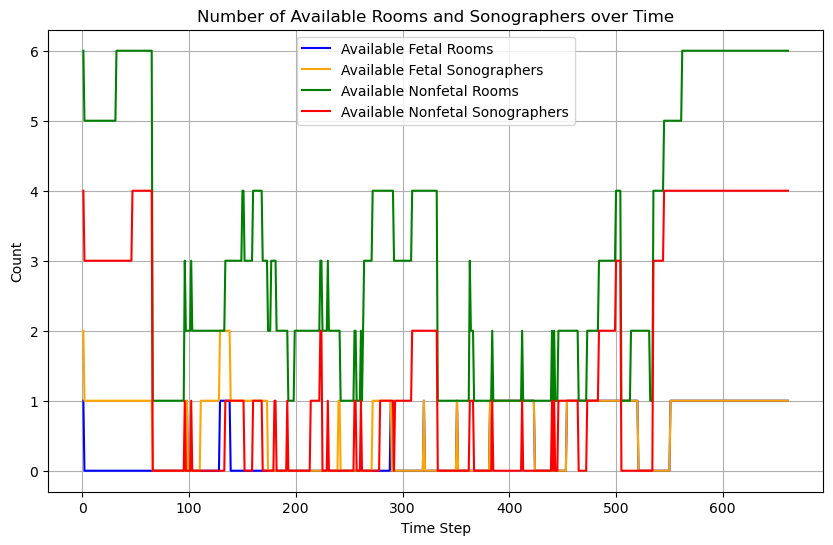

In [5]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot number of available fetal rooms
plt.plot(time_steps, available_fetal_room, label='Available Fetal Rooms', color='blue')

# Plot number of available fetal sonographers
plt.plot(time_steps, available_fetal_sonographer, label='Available Fetal Sonographers', color='orange')

# Plot number of available nonfetal rooms
plt.plot(time_steps, available_nonfetal_room, label='Available Nonfetal Rooms', color='green')

# Plot number of available nonfetal sonographers
plt.plot(time_steps, available_nonfetal_sonographer, label='Available Nonfetal Sonographers', color='red')



# Set labels and title
plt.xlabel('Time Step')
plt.ylabel('Count')
plt.title('Number of Available Rooms and Sonographers over Time')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()


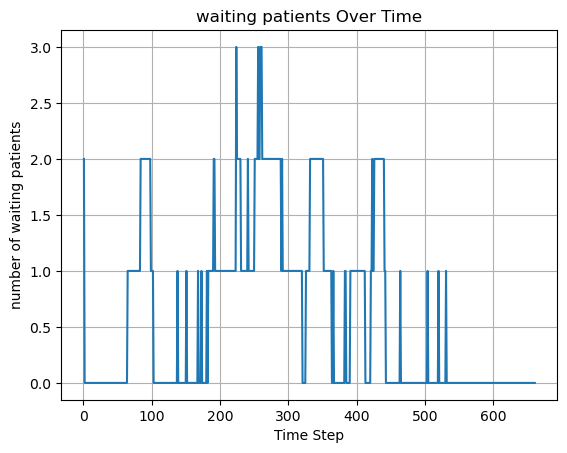

In [6]:
plt.plot(time_steps, waiting_patients)
plt.xlabel('Time Step')
plt.ylabel('number of waiting patients')
plt.title('waiting patients Over Time')
plt.grid(True)
plt.show()

In [ ]:
# Combine the two lists
all_nonfetal_patients = [{'Time': patient['Schedule time']} for patient in sim.state['patients'] if patient['fetal'] == 'no']

# Extract Schedule Time and Status
schedule_times = [patient['Time'] for patient in all_nonfetal_patients]

# Count occurrences of each Schedule Time
schedule_time_counts = {}
for time in schedule_times:
    schedule_time_counts[time] = schedule_time_counts.get(time, 0) + 1

# Sort the schedule times
sorted_schedule_time_counts = dict(sorted(schedule_time_counts.items()))

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_schedule_time_counts.keys(), sorted_schedule_time_counts.values(), color='blue')
plt.xlabel('Schedule Time')
plt.ylabel('Number of appointment schedules')
plt.title('Number of Patients by Schedule Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [ ]:
# Combine the two lists
all_fetal_patients = [{'Time': patient['Schedule time']} for patient in sim.state['patients'] if patient['fetal'] == 'yes']

# Extract Schedule Time and Status
schedule_times = [patient['Time'] for patient in all_fetal_patients]
# Count occurrences of each Schedule Time
schedule_time_counts = {}
for time in schedule_times:
    schedule_time_counts[time] = schedule_time_counts.get(time, 0) + 1

# Sort the schedule times
sorted_schedule_time_counts = dict(sorted(schedule_time_counts.items()))

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_schedule_time_counts.keys(), sorted_schedule_time_counts.values(), color='blue')
plt.xlabel('Schedule Time')
plt.ylabel('Number of appointment schedules')
plt.title('Number of Patients by Schedule Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [ ]:
## import matplotlib.pyplot as plt

def convert_to_step(time):
    hours, minutes = map(int, time.split(':'))
    step = hours * 60 + minutes - 480
    return step

# Combine the two lists
all_patients = [{'Time': convert_to_step(patient['Arrival time']) - convert_to_step(patient['Schedule time'])} for patient in sim.state['patients']]


# Extract Schedule Time and Status
schedule_times = [patient['Time'] for patient in all_patients]

# Create KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(schedule_times, shade=True, color='blue')
plt.xlabel('Difference between Arrival and Schedule Time (in minutes)')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Difference between Arrival and Schedule Time')
plt.show()


In [ ]:
# Define the schedules function with parameters
def schedules(time_start, time_close):
    # Initialize an empty list to store the schedule
    schedule = []

    # Define the convert_to_step function (assuming it's defined elsewhere in your code)
    def convert_to_step(time_str):
        # Your implementation here
        hours, minutes = map(int, time_str.split(':'))
        step = hours * 60 + minutes - 480  # 480 minutes equal to 8 hours
        return step

    # Calculate the number of time steps based on the time range
    time_range = convert_to_step(time_close) - convert_to_step(time_start) + 1

    # Iterate over each time step
    for time in range(time_range):
        # Initialize a dictionary to represent the schedule at each time step
        schedule_at_time = {
            "time": time,
            "fetal patients": 0,
            "nonfetal patients": 0
        }
        # Append the schedule for the current time step to the list
        schedule.append(schedule_at_time)

    # Loop through the schedule to handle patient scheduling
    for schedule_entry in schedule:
        # Check if it's time to schedule a fetal patient (assuming 60 is the interval)
        if schedule_entry['time'] % 60 == 0:
            schedule_entry["fetal patients"] = 1

        # Check if it's time to schedule a nonfetal patient (assuming 30 is the interval)
        if schedule_entry['time'] % 30 == 0:
            # Check specific intervals where there are two appointments
            if (convert_to_step('10:30') <= schedule_entry['time'] <= convert_to_step('12:30')) or \
               (convert_to_step('14:00') <= schedule_entry['time'] <= convert_to_step('15:30')):
                schedule_entry["nonfetal patients"] = 2
            else:
                schedule_entry["nonfetal patients"] = 1

        # Handle specific appointments made at different times
        if schedule_entry['time'] in [convert_to_step('10:45'), convert_to_step('11:45')]:
            schedule_entry["nonfetal patients"] = 1

    # Return the populated schedule
    return schedule

# Define the time_start and time_close variables
time_start = '08:00'
time_close = '13:00'

# Call the schedules function to populate the schedule list
schedule = schedules(time_start, time_close)

# Print the schedule list
print(schedule)


In [ ]:
if True:
    a=1
print(a)


In [ ]:
### policy 5                                
                # reserve the sonographer and the echo room if they are available 10 mins before the schedule
                elif action == 5:
                  patient_reservation=[]
                    for patient in self.patients:
                       # Check if the time difference is within 10 units
                        if 0 <= patient['Schedule time'] - self.env.now <= 10 and patient['status']='incoming':
                            patient_reservation.append(patient)
                    for patient in patient_reservation:
                        
